# NEMO biases

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean 
from scipy.stats import linregress

In [29]:
from dask.distributed import Client, LocalCluster, wait

In [30]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45057 instead
  http_address["port"], self.http_server.port


In [31]:
client

Client Scheduler: tcp://127.0.0.1:33695 Dashboard: http://127.0.0.1:45057/status,Cluster Workers: 4 Cores: 8 Memory: 64.00 GB


In [32]:
ds_mesh = xr.open_dataset('/data/user/jkjellsson/orca05_mesh_mask.nc')
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_volume = (ds_mesh['e1t'] * ds_mesh['e2t'] * ds_mesh['e3t']).sel(t=0).rename({'z':'deptht'})
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)
da_orca05_mask_3D = ds_mesh['tmask'].sel(t=0).rename({'z':'deptht'})

In [33]:
exp_list = ['focioifs-merge14']

In [34]:
# NEMO grid T
ds_t_all = []
for exp in exp_list:
    t = '/data/user/jkjellsson/esm-experiments/focioifs/%s/outdata/nemo/*1m*grid_T.nc' % (exp,)
    ds_t = xr.open_mfdataset(t,combine='by_coords').rename({'time_counter':'time'})
    ds_t_all.append(ds_t)

## Temperature and salinity

KilledWorker: ("('concatenate-open_dataset-getitem-298908a40d9e92800fdc7976ea2595b2', 1, 0, 0, 0)", <Worker 'tcp://127.0.0.1:40049', name: 2, memory: 0, processing: 1>)

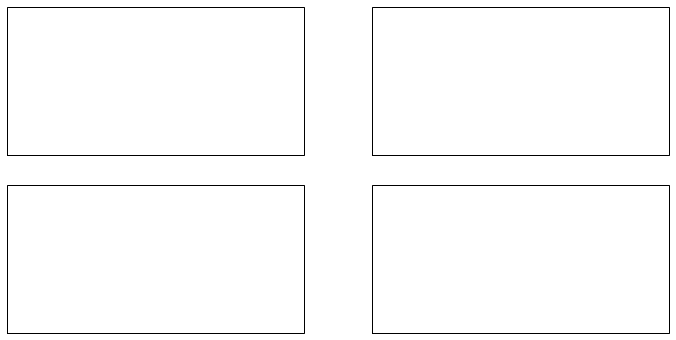

In [37]:
# Plot settings
prj = ccrs.PlateCarree()
tmin1 = -2
tmax1 = 28
tmin2 = -5
tmax2 = 5
smin1 = 20
smax1 = 38
smin2 = -2
smax2 = 2

tmap1 = cmocean.cm.thermal
tmap2 = cmocean.cm.balance
smap1 = cmocean.cm.haline
smap2 = cmocean.cm.balance

# WOA T,S in ORCA05 grid
woat = '/data/user/swahl/foci_input/NEMO/input/r0001/ORCA05/Levitus_p2.1_1m_01_12_Tpot_ORCA_R05.nc'
woas = '/data/user/swahl/foci_input/NEMO/input/r0001/ORCA05/Levitus_p2.1_1m_01_12_S_correc_ORCA_R05.nc'

ds_woat = xr.open_dataset(woat).rename({'z':'deptht'})
ds_woas = xr.open_dataset(woas).rename({'z':'deptht'})

# WOA data is missing good time axis
# So we make one
attrs = {"units": "days since 2000-01-15"}
ds = xr.Dataset({"time_counter": ("time_counter", [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334], attrs)})
ds_t = xr.decode_cf(ds)

ds_woat_t = ds_woat['votemper'].assign_coords(time_counter = ds_t['time_counter'])
t_woa = ds_woat_t.mean('time_counter')
ds_woas_t = ds_woas['vosaline'].assign_coords(time_counter = ds_t['time_counter'])
s_woa = ds_woas_t.mean('time_counter')

for i in range(0,len(ds_t_all)):
    exp = exp_list[i]
    ds_t = ds_t_all[i]
    
    temp = ds_t['votemper'][-360:].mean('time') 
    salt = ds_t['vosaline'][-360:].mean('time') 
    
    dtemp = temp - t_woa
    dsalt = salt - s_woa
    
    for depth in [300,700,1500,3000,5000]:
        fig = plt.figure(figsize=(12,6))
        axs = []
        axs.append( fig.add_subplot(2,2,1,projection=prj) )
        axs.append( fig.add_subplot(2,2,2,projection=prj) )
        axs.append( fig.add_subplot(2,2,3,projection=prj) )
        axs.append( fig.add_subplot(2,2,4,projection=prj) )
        
        dtemp_lev = dtemp.sel(deptht=depth,method='nearest').compute()
        print(dtemp_lev)
        dsalt_lev = dsalt.sel(deptht=depth,method='nearest').compute()
        
        
        ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'SST [K]'}
        dtemp.plot(ax=axs[0],vmin=tmin1,vmax=tmax1,cmap=tmap1,cbar_kwargs=ckw)
        
        ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'CI [fraction]'}
        dsalt.plot(ax=axs[2],vmin=smin1,vmax=smax1,cmap=smap1,cbar_kwargs=ckw)
        
        axs[0].set_title('Temp (%s): %s' % (season,exp))
        axs[1].set_title('Temp (%s): %s - HadISST' % (season,exp))
        axs[2].set_title('Salin (%s): %s' % (season,exp))
        axs[3].set_title('Salin (%s): %s - HadISST' % (season,exp))
        
        fig.tight_layout()
        fig.savefig('temp_salin_biases_%s.png' % (season,),format='png',dpi=600)


## Surface pressure and zonal wind

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, lat: 96, lon: 192, time: 2640)
Coordinates:
  * lat                   (lat) float32 -89.0625 -87.1875 ... 87.1875 89.0625
  * lon                   (lon) float32 0.9375 2.8125 ... 357.1875 359.0625
    time_centered         (time) datetime64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 1850-01-16T12:00:00 ... 2069-12-16T12:00:00
Dimensions without coordinates: axis_nbounds
Data variables:
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    sz                    (time, lat, lon) float32 dask.array<chunksize=(12, 96, 192), meta=np.ndarray>
    ci                    (time, lat, lon) float32 dask.array<chunksize=(12, 96, 192), meta=np.ndarray>
    sstk                  (time, lat, lon) float32 dask.array<chunksi

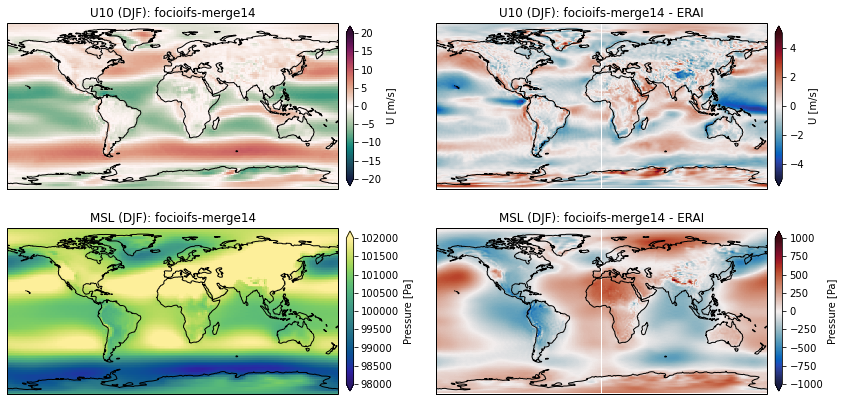

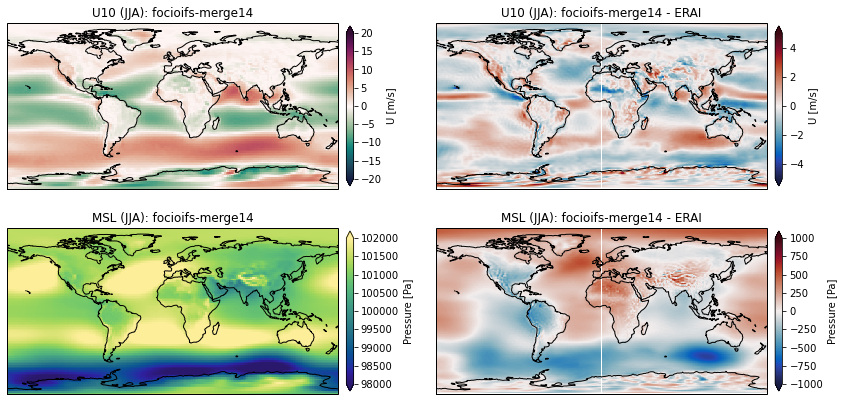

In [49]:
# Plot settings
prj = ccrs.PlateCarree()
umin1 = -20
umax1 = 20
umin2 = -5
umax2 = 5
pmin1 = 98000
pmax1 = 102000
pmin2 = -1000
pmax2 = 1000

umap1 = cmocean.cm.curl
umap2 = cmocean.cm.balance
pmap1 = cmocean.cm.haline
pmap2 = cmocean.cm.balance

# ERA-Int
era_msl = '/data/user/swahl/reanalysis_obs/era40-int/surface/msl/msl-eraint_monthly_0.75deg_1979-2017.nc'
era_u10 = '/data/user/swahl/reanalysis_obs/era40-int/surface/u10/u10-eraint_monthly_0.75deg_1979-2017.nc'

ds_era_msl = xr.open_dataset(era_msl)#.rename({'longitude':'lon','latitude':'lat'})
ds_era_u10 = xr.open_dataset(era_u10)#.rename({'longitude':'lon','latitude':'lat'})

msl_ei = ds_era_msl['MSL'].sel(time=slice('1980-01-01','2010-01-01')).groupby('time.season').mean('time')
u10_ei = ds_era_u10['U10M'].sel(time=slice('1980-01-01','2010-01-01')).groupby('time.season').mean('time')

for i in range(0,len(ds_sfc_all)):
    exp = exp_list[i]
    ds_sfc = ds_sfc_all[i]
    print(ds_sfc)
    
    u10 = ds_sfc['10u'][-360:].groupby('time.season').mean('time') 
    msl = ds_sfc['msl'][-360:].groupby('time.season').mean('time') 
    
    u10_i = u10.interp_like(u10_ei)
    msl_i = msl.interp_like(msl_ei)
    
    for season in ['DJF','JJA']:
        fig = plt.figure(figsize=(12,6))
        axs = []
        axs.append( fig.add_subplot(2,2,1,projection=prj) )
        axs.append( fig.add_subplot(2,2,2,projection=prj) )
        axs.append( fig.add_subplot(2,2,3,projection=prj) )
        axs.append( fig.add_subplot(2,2,4,projection=prj) )
        
        ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'U [m/s]'}
        u10.sel(season=season).plot(ax=axs[0],vmin=umin1,vmax=umax1,cmap=umap1,cbar_kwargs=ckw)
        (u10_i - u10_ei).sel(season=season).plot(ax=axs[1],cmap=umap2,vmin=umin2,vmax=umax2,cbar_kwargs=ckw)
        
        ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'Pressure [Pa]'}
        msl.sel(season=season).plot(ax=axs[2],vmin=pmin1,vmax=pmax1,cmap=pmap1,cbar_kwargs=ckw)
        (msl_i - msl_ei).sel(season=season).plot(ax=axs[3],cmap=pmap2,vmin=pmin2,vmax=pmax2,cbar_kwargs=ckw)
        
        axs[1].set_title('U10 (%s): %s - ERAI' % (season,exp))
        axs[0].set_title('U10 (%s): %s' % (season,exp))
        axs[3].set_title('MSL (%s): %s - ERAI' % (season,exp))
        axs[2].set_title('MSL (%s): %s' % (season,exp))
        
        for ax in axs:
            ax.coastlines()
            #ax.set_extent([-100,30,10,90],crs=prj)
        
        fig.tight_layout()
        fig.savefig('u10_msl_biases_%s.png' % (season,),format='png',dpi=600)


## Temperature